In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

llm=ChatGroq(model="llama-3.1-8b-instant")

In [3]:
from typing import Literal
from pydantic import BaseModel,Field

class Route(BaseModel):
    step:Literal["joke","poem","story"]=Field(description="The next step in the routing process")

In [4]:
router = llm.with_structured_output(Route)

In [5]:
from typing import TypedDict
from langchain_core.messages import HumanMessage,SystemMessage


class State(TypedDict):
    input:str
    decision:str
    output:str

def story_writer(state: State):
    print("story_writer is called")
    result = llm.invoke(state["input"])
    return {"output": result.content}

def joke_teller(state: State):
    print("joke_teller is called")
    result = llm.invoke(state["input"])
    return {"output": result.content}

def poet(state: State):
    print("poet is called")
    result = llm.invoke(state["input"])
    return {"output": result.content}

def router_call(state:State):
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to story,joke or poem based on the users request"
            ),
            HumanMessage(content=state["input"])
        ]
    )
    return {"decision":decision.step}


In [ ]:
def route_decision(state: State):
    if state["decision"] == "story":
        return "story_writer"
    elif state["decision"] == "joke":
        return "joke_teller"
    elif state["decision"] == "poem":
        return "poet"

In [7]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

router_builder = StateGraph(State)

router_builder.add_node("story_writer", story_writer)
router_builder.add_node("joke_teller", joke_teller)
router_builder.add_node("poet", poet)
router_builder.add_node("router_call", router_call)

# Add edges to connect nodes
router_builder.add_edge(START, "router_call")
router_builder.add_conditional_edges(
    "router_call",
    route_decision,
    { 
        "story_writer": "story_writer",
        "joke_teller": "joke_teller",
        "poet": "poet",
    },
)
router_builder.add_edge("story_writer", END)
router_builder.add_edge("joke_teller", END)
router_builder.add_edge("poet", END)

router_workflow = router_builder.compile()


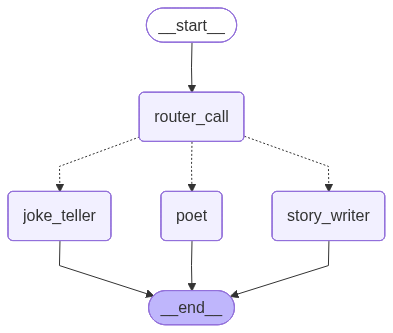

In [8]:
display(Image(router_workflow.get_graph().draw_mermaid_png()))

In [12]:
state=router_workflow.invoke({"input":"Write me a joke about Software Industry in India"})
print(state["output"])

joke_teller is called
Why did the Indian software engineer bring a ladder to work? 

Because he wanted to take his coding skills to the next level, but his manager just wanted to reach the ceiling for more profits.
